In [1]:
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from typing import Callable, Optional
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
import thinker
import thinker.viz_utils as viz
import thinker.util as util
import gym
import gym_sokoban
import torch.nn.functional as F
import pandas as pd
import numpy as np
from celluloid import Camera
from thinker.actor_net import DRCNet
import os
import random

/home/tom/mlmi/dissertation/working_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-31 16:00:15,695	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.



In [2]:
class ProbingDataset(Dataset):
    def __init__(self, data: list):
        self.data = data
    def __len__(self) -> int:
        return len(self.data)
    def __getitem__(self, index: int) -> dict:
        return self.data[index]
    def get_feature_range(self, feature: str) -> tuple[int, int]:
        assert feature in self.data[0].keys(), f"Please enter a feature in dataset: {self.data[0].keys()}"
        min_feature_value, max_feature_value = self.data[0][feature], self.data[0][feature]
        for entry in self.data:
            if entry[feature] > max_feature_value:
                max_feature_value = entry[feature]
            elif entry[feature] < min_feature_value:
                min_feature_value = entry[feature]
        return (min_feature_value, max_feature_value)


class ProbingDatasetCleaned(Dataset):
    def __init__(self, data: list):
        self.data = data
    def __len__(self) -> int:
        return len(self.data)
    def __getitem__(self, index: int) -> tuple:
        return self.data[index]  

In [5]:
val_data = torch.load("../probing/data/val_data_full.pt")

In [6]:
ep_len = 3
ep_start = 50
layer = 2
channel = 7
vmin = -1
vmax = 1

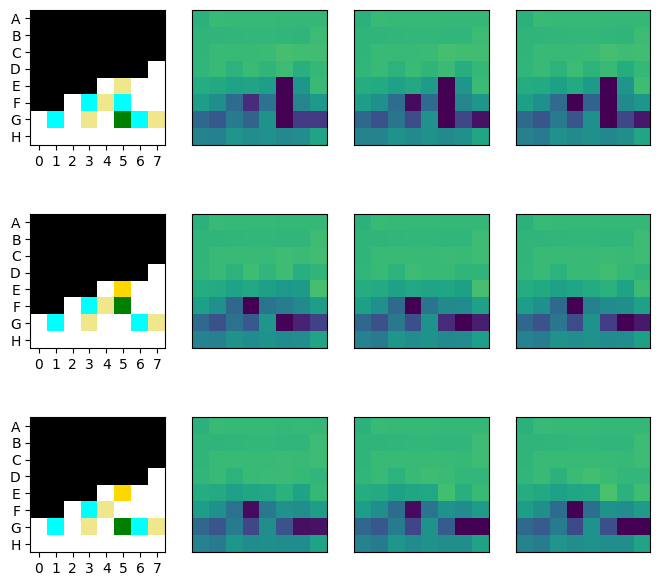

In [13]:
fig, axs = plt.subplots(ep_len, 4, figsize=(8,ep_len*2.5))

for k in range(ep_len):
    trans = val_data[ep_start+k]
    state = trans["board_state"]
    if state.shape[0] != state.shape[1]:
        state = state.permute(1,2,0)
    dim_z = 7
    mini_board = np.zeros(state.shape[:-1])
    for i in range(1,1+dim_z):
        mini_board[(state[:,:,i-1] == 1)] = i
    mini_board = np.flip(mini_board, axis=0)
    cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
    bounds= [i+0.5 for i in range(1+dim_z)]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    axs[k][0].imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    axs[k][0].set_xticks(range(8), labels=range(8))
    axs[k][0].set_yticks(range(8), reversed(["A", "B", "C", "D", "E", "F", "G", "H"]))
    #axs[k][0].axes.get_xaxis().set_visible(False)
    axs[k][1].imshow(trans["hidden_states"][1,64*layer+32+channel,:,:], vmin=vmin,vmax=vmax)
    axs[k][1].axes.get_yaxis().set_visible(False)
    axs[k][1].axes.get_xaxis().set_visible(False)
    axs[k][2].imshow(trans["hidden_states"][2,64*layer+32+channel,:,:], vmin=vmin,vmax=vmax)
    axs[k][2].axes.get_yaxis().set_visible(False)
    axs[k][2].axes.get_xaxis().set_visible(False)
    axs[k][3].imshow(trans["hidden_states"][3,64*layer+32+channel,:,:], vmin=vmin,vmax=vmax)
    axs[k][3].axes.get_yaxis().set_visible(False)
    axs[k][3].axes.get_xaxis().set_visible(False)
plt.show()

In [3]:
j = 0
exp = "plantest"
num_steps = 10
reset = True

In [4]:
mini_sokoban = True
mini_unqtar = False
mini_unqbox = False
env_n = 1
all_results = []
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
flags.mini = mini_sokoban
flags.mini_unqbtar = mini_unqtar
flags.mini_unqbox = mini_unqbox


print(f"--------------- {j:04} ----------------")

results = {}
env = thinker.make(
    f"Sokoban-{exp}_corrupt_{j:04}-v0", 
    env_n=env_n, 
    gpu=False,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
) 

drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)
ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)

clean_activs = []
clean_boards = []
corrupt_activs = []
corrupt_boards = []

rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
state = env.reset()
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
for step in range(num_steps):
    actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
    clean_activs.append(drc_net.hidden_state[:,1:,:,:].detach())
    clean_boards.append(state["real_states"][0].detach())
    state, reward, done, info = env.step(actor_out.action)
    env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
    if reset:
        rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)

clean_loc = state["real_states"][0,[4,5],:,:].sum(dim=0).argmax()
env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
actor_out, _ = drc_net(env_out, rnn_state, greedy=True)
clean_activs.append(drc_net.hidden_state[:,1:,:,:].detach())
clean_boards.append(state["real_states"][0].detach())

env = thinker.make(
    f"Sokoban-{exp}_{'clean' if reset else 'corrupt'}_{j:04}-v0", 
    env_n=env_n, 
    gpu=False,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
    ) 

rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
state = env.reset()
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
for step in range(num_steps):
    actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
    corrupt_activs.append(drc_net.hidden_state[:,1:,:,:].detach())
    corrupt_boards.append(state["real_states"][0].detach())
    state, reward, done, info = env.step(actor_out.action)
    env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)

corrupt_loc = state["real_states"][0,[4,5],:,:].sum(dim=0).argmax()
env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
actor_out, _ = drc_net(env_out, rnn_state, greedy=True)
corrupt_activs.append(drc_net.hidden_state[:,1:,:,:].detach())
corrupt_boards.append(state["real_states"][0].detach())

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


--------------- 0000 ----------------


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


In [5]:
layer = 2
channel = 28
vmin = -2
vmax = 2
channel2 = -2

Text(0.5, 1.0, 'Corrupt Tick 3')

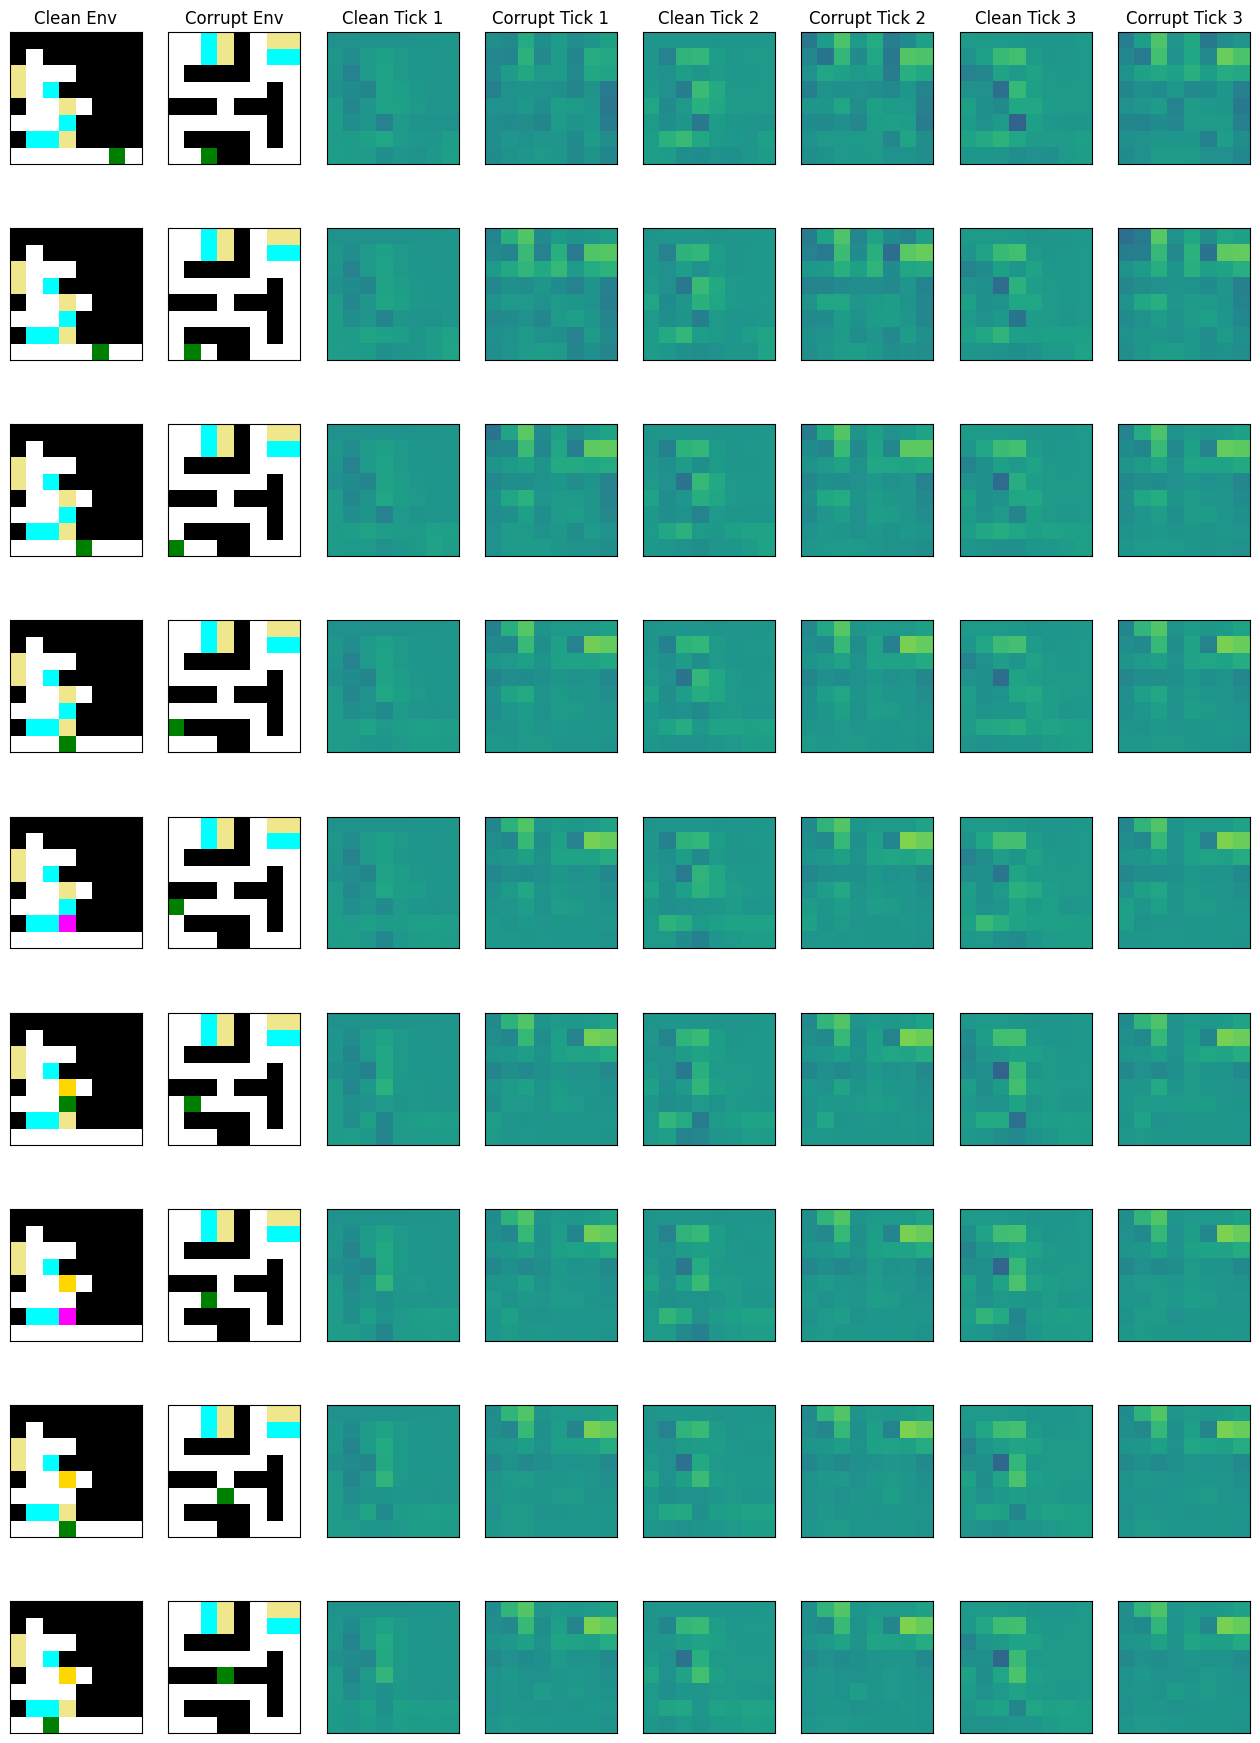

In [6]:
fig, axs = plt.subplots(num_steps-1, 8, figsize=(16,(num_steps-1)*2.5))
for k in range(num_steps-1):
    
    clean_state = clean_boards[k]
    if clean_state.shape[0] != clean_state.shape[1]:
        clean_state = clean_state.permute(1,2,0)
    dim_z = 7
    mini_board_clean = np.zeros(clean_state.shape[:-1])
    for i in range(1,1+dim_z):
        mini_board_clean[(clean_state[:,:,i-1] == 1)] = i
    mini_board_clean = np.flip(mini_board_clean, axis=0)

    corrupt_state = corrupt_boards[k]
    if corrupt_state.shape[0] != corrupt_state.shape[1]:
        corrupt_state = corrupt_state.permute(1,2,0)
    dim_z = 7
    mini_board_corrupt = np.zeros(corrupt_state.shape[:-1])
    for i in range(1,1+dim_z):
        mini_board_corrupt[(corrupt_state[:,:,i-1] == 1)] = i
    mini_board_corrupt = np.flip(mini_board_corrupt, axis=0)

    cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
    bounds= [i+0.5 for i in range(1+dim_z)]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    axs[k][0].imshow(mini_board_clean, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    axs[k][0].axes.get_yaxis().set_visible(False)
    axs[k][0].axes.get_xaxis().set_visible(False)
    axs[k][1].imshow(mini_board_corrupt, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    axs[k][1].axes.get_yaxis().set_visible(False)
    axs[k][1].axes.get_xaxis().set_visible(False)
    axs[k][2].imshow(clean_activs[k][0,0,64*layer+32+channel,:,:] + (clean_activs[k][0,0,64*layer+32+channel2,:,:] if channel2 > -1 else 0), vmin=vmin,vmax=vmax)
    axs[k][2].axes.get_yaxis().set_visible(False)
    axs[k][2].axes.get_xaxis().set_visible(False)
    axs[k][3].imshow(corrupt_activs[k][0,0,64*layer+32+channel,:,:] +(corrupt_activs[k][0,0,64*layer+32+channel2,:,:] if channel2 > -1 else 0), vmin=vmin,vmax=vmax)
    axs[k][3].axes.get_yaxis().set_visible(False)
    axs[k][3].axes.get_xaxis().set_visible(False)

    axs[k][4].imshow(clean_activs[k][0,1,64*layer+32+channel,:,:] + (clean_activs[k][0,1,64*layer+32+channel2,:,:] if channel2 > -1 else 0), vmin=vmin,vmax=vmax)
    axs[k][4].axes.get_yaxis().set_visible(False)
    axs[k][4].axes.get_xaxis().set_visible(False)
    axs[k][5].imshow(corrupt_activs[k][0,1,64*layer+32+channel,:,:] + (corrupt_activs[k][0,1,64*layer+32+channel2,:,:] if channel2 > -1 else 0), vmin=vmin,vmax=vmax)
    axs[k][5].axes.get_yaxis().set_visible(False)
    axs[k][5].axes.get_xaxis().set_visible(False)

    axs[k][6].imshow(clean_activs[k][0,2,64*layer+32+channel,:,:] + (clean_activs[k][0,2,64*layer+32+channel2,:,:] if channel2 > -1 else 0), vmin=vmin,vmax=vmax)
    axs[k][6].axes.get_yaxis().set_visible(False)
    axs[k][6].axes.get_xaxis().set_visible(False)
    axs[k][7].imshow(corrupt_activs[k][0,2,64*layer+32+channel,:,:] + (corrupt_activs[k][0,2,64*layer+32+channel2,:,:] if channel2 > -1 else 0), vmin=vmin,vmax=vmax)
    axs[k][7].axes.get_yaxis().set_visible(False)
    axs[k][7].axes.get_xaxis().set_visible(False)

axs[0][0].set_title("Clean Env")
axs[0][1].set_title("Corrupt Env")
axs[0][2].set_title("Clean Tick 1")
axs[0][3].set_title("Corrupt Tick 1")
axs[0][4].set_title("Clean Tick 2")
axs[0][5].set_title("Corrupt Tick 2")
axs[0][6].set_title("Clean Tick 3")
axs[0][7].set_title("Corrupt Tick 3")